In [381]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from transformer_onestep_CL import GPTClosedLoop
import tqdm
import argparse

In [382]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [383]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [384]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [385]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [386]:
torch.cuda.is_available()

True

In [387]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_evaporation_v3.pt", map_location=device)

In [388]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [389]:
# del exp_data["model_args"]['use_pi']

In [390]:
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model_CL = GPTClosedLoop(gptconf).to(device)

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_CL.load_state_dict(state_dict)
model = model_CL.gpt_model

number of parameters: 0.10M


In [391]:
exp_data.keys()

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

In [392]:
exp_data['best_val_loss']

0.5428173542022705

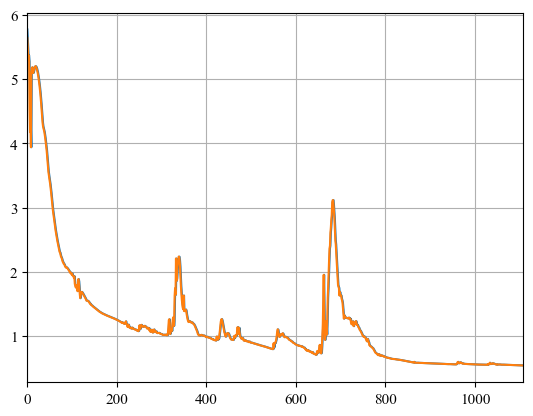

In [393]:
plt.plot(exp_data['LOSS'])
plt.plot(exp_data['LOSS_VAL'])
# plt.xlim([0, 2000])

In [394]:
exp_data['train_time'] / 3600

10.08860502322515

In [395]:
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, drss_matrices
set_seed(42)  

seq_len = 300   
nx = 2
nu = 1
ny = 1
 
# define settings
ts = 1  

# define nominal model
G = drss_matrices(nx, nu, ny, device=device)

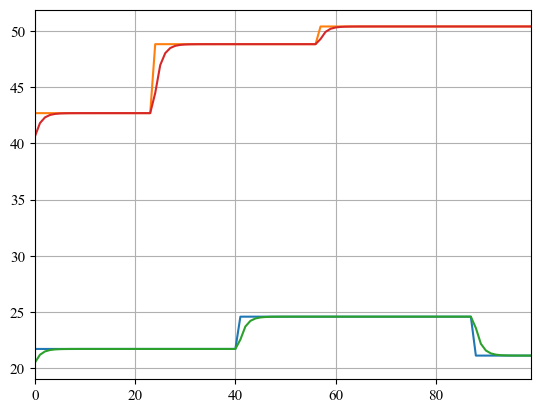

In [396]:
from signals_torch import steps_sequence
from dataset_CL_evaporation_process import EvaporationDataset

seq_len = 100
ts = 1

dataset = EvaporationDataset(seq_len=seq_len, ts=ts, seed=42, data_perturb_percentage=0)
dataloader = DataLoader(dataset, batch_size=batch_size)
data, batch_r, batch_y_d = next(iter(dataloader))

# T = 100
# t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)
# r = torch.zeros((T,2), device=device, dtype=torch.float32)
# 
# r[:,0] = steps_sequence(T, ts, 20, 25, 20, 50).T
# r[:,1] = steps_sequence(T, ts, 40, 60, 20, 50).T
r = batch_r[0,:,:]
y_d = batch_y_d[0,:,:]
t = torch.arange(0, seq_len, ts, device=device, dtype=torch.float32).view(-1, 1)

plt.plot(t.cpu().numpy(), r.cpu().numpy())
plt.plot(t.cpu().numpy(), y_d.cpu().numpy())

In [397]:
print(model.proportional_coefficient)
print(model.integral_coefficient)
print(model.derivative_coefficient)

Parameter containing:
tensor([2.3480], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.3098], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.2415], device='cuda:0', requires_grad=True)


In [398]:
from evaporation_process import problem_data, dynamics
import pickle as pkl
H = 100

n_test = 1    
E_log = np.zeros((n_test, len(t), 2))
U_log = np.zeros((n_test, len(t), 2))
Y_log = np.zeros((n_test, len(t), 2))

for key in range(n_test):
    
    E = torch.empty((n_test, len(t), 2), device=device, dtype=torch.float32)
    U = torch.empty((n_test, len(t)+1, 2), device=device, dtype=torch.float32)
    Y = torch.empty((n_test, len(t), 2), device=device, dtype=torch.float32)
    
    with torch.no_grad():
        # initial
        U[0, 0, :] = torch.tensor([191.713, 215.888], device=device, dtype=torch.float32).unsqueeze(0).repeat(1, 1)
        y_i = batch_y_d[:,0,:]
        x_i = y_i.clone()
        
        for i in range(len(t)):
            
            # print('time instant:', i)
            # start the loop with error
            e_i = r[i] - y_i

            Y[0,i,:] = y_i
            E[0,i,:] = e_i
            
            # Controller u(t) = C(e(t),u(t-1))
            if i < H:
                pred = model(E[:, :i+1, :], U[:, :i+1, :])
            else:
                pred = model(E[:, i-H+1:i+1, :], U[:, i-H+1:i+1, :])
                
            U[:, i+1, :] = pred[:,-1,:]  # Just for coherence

            # Simulate system response
            x_dot = dynamics(x_i[0], U[0, i+1, :], *data)
            # Integrate dynamics using forward Euler integration
            y_i = x_i + ts * x_dot
            x_i = y_i.clone()
            
    E_log[key] = E[0,:,:].cpu().numpy()
    U_log[key] = U[0,1:,:].cpu().numpy()
    Y_log[key] = Y[0,:,:].cpu().numpy()
    
    if key == n_test-1:
        break

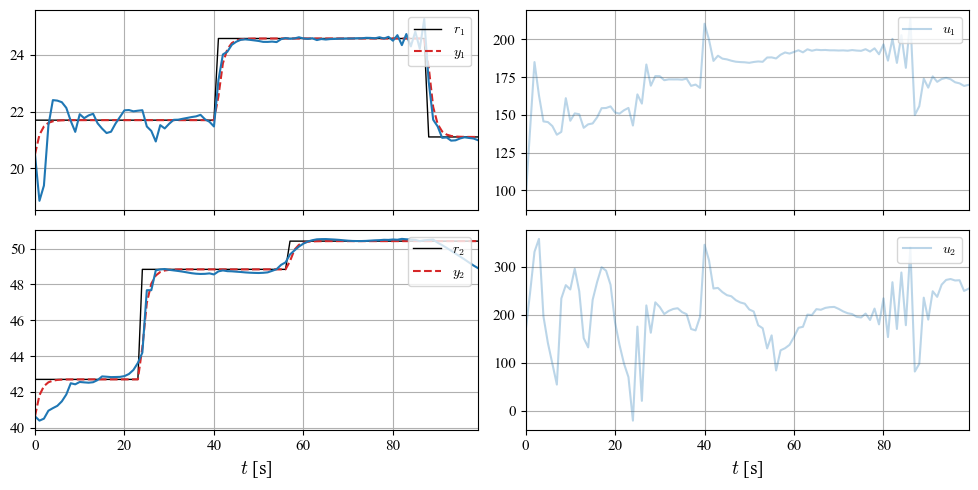

In [399]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(221)
#plt.plot(t_CL, r)
plt.plot(t.cpu().numpy(), r[:,0].cpu().numpy(), label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), y_d[:,0].cpu().numpy(), label="$y_d$", c='tab:red', linestyle='--')
plt.plot(t.cpu().numpy(), Y_log[0,:,0].T, c='tab:blue', alpha=1)
plt.legend(['$r_1$','$y_1$'], loc='upper right')
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(t.cpu().numpy(), r[:,1].cpu().numpy(), label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), y_d[:,1].cpu().numpy(), label="$y_d$", c='tab:red', linestyle='--')
plt.plot(t.cpu().numpy(), Y_log[0,:,1].T, c='tab:blue', alpha=1)
plt.legend(['$r_2$','$y_2$'], loc='upper right')
plt.xlabel('$t$ [s]')
# plt.xlim([10, 12])


ax3 = plt.subplot(222, sharex=ax1)
plt.plot(t.cpu().numpy(), U_log[0,:,0].T, c='tab:blue', alpha=.3)
# plt.ylim([0, 4])
plt.legend(['$u_1$'], loc='upper right')
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(224, sharex=ax1)
plt.plot(t.cpu().numpy(), U_log[0,:,1].T, c='tab:blue', alpha=.3)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$u_2$'], loc='upper right')

# plt.savefig('transformer_controller.pdf')
# Improve the layout to avoid overlapping
plt.tight_layout()

plt.show()